# Predicting Toronto Ferry Activity

## Install libraries

In [ ]:
# Data handling and analysis
!pip install pandas numpy

# Plotting
!pip install matplotlib seaborn

# Time series decomposition and stats
!pip install statsmodels

# scikit-learn
!pip install scikit-learn

# Holiday calendars
!pip install holidays

# YAML configuration parsing
!pip install pyyaml

# LightGBM
!pip install lightgbm

# SHAP values for model explainability
!pip install shap


## Import packages

In [1]:
# Standard library imports
from datetime import date, timedelta

# Numerical and data analysis libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

# Machine learning libraries
import lightgbm as lgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import MinMaxScaler

# Model explainability
import shap

# Holiday calendars
import holidays

# For LSTM
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch

#For importing files
import yaml



C:\Users\khiza\AppData\Local\Temp\ipykernel_18288\2316165785.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Custom classes and functions

In [3]:
class CSVDataLoader:
    """
    A class to load and preprocess time-series data from a CSV file.

    Attributes:
        file_path (str): Path to the CSV file.
        id_col (str): Name of the column containing unique identifiers.
        timestamp_col (str): Name of the column containing timestamp values.
        redemption_col (str): Name of the column containing redemption counts.
        sales_col (str): Name of the column containing sales counts.
        df (pd.DataFrame or None): Loaded and preprocessed DataFrame.
    """

    def __init__(self, file_path, id_col, timestamp_col, redemption_col, sales_col):
        """
        Initializes the DataLoader with file path and relevant column names.

        Args:
            file_path (str): Path to the CSV file.
            id_col (str): Column name for IDs.
            timestamp_col (str): Column name for timestamps.
            redemption_col (str): Column name for redemption data.
            sales_col (str): Column name for sales data.
        """
        self.file_path = file_path
        self.id_col = id_col
        self.timestamp_col = timestamp_col
        self.redemption_col = redemption_col
        self.sales_col = sales_col
        self.df = None

    def load_data(self):
        """
        Loads the CSV data, parses dates, sorts by timestamp, 
        and sets the timestamp column as the index.

        Returns:
            pd.DataFrame: Preprocessed DataFrame with timestamp index.
        """
        self.df = pd.read_csv(
            self.file_path,
            dtype={self.id_col: int, self.redemption_col: int, self.sales_col: int},
            parse_dates=[self.timestamp_col]
        )
        self.df.sort_values(self.timestamp_col, inplace=True)
        self.df.set_index(self.timestamp_col, inplace=True)
        return self.df


class BasicDataAnalyzer:
    """
    A class for performing basic exploratory data analysis (EDA) on time-series data.

    Attributes:
        df (pd.DataFrame): The input DataFrame containing time-series data.
        redemption_col (str): Column name for redemption data.
        sales_col (str): Column name for sales data.
        id_col (str, optional): Column name for unique identifiers, if any.
    """

    def __init__(self, df, redemption_col, sales_col, id_col=None):
        """
        Initializes the BasicDataAnalyzer with the dataset and relevant column names.

        Args:
            df (pd.DataFrame): Input DataFrame.
            redemption_col (str): Column name for redemption data.
            sales_col (str): Column name for sales data.
            id_col (str, optional): Column name for ID data. Defaults to None.
        """
        self.df = df
        self.redemption_col = redemption_col
        self.sales_col = sales_col
        self.id_col = id_col

    def perform_basic_eda(self):
        """
        Performs basic exploratory data analysis:
            - Displays summary statistics
            - Displays missing value counts
            - Plots time series for redemption and sales
            - Displays and plots correlation matrix
        """
        print("Summary Statistics (excluding ID column):")
        cols_to_describe = [self.redemption_col, self.sales_col]
        print(self.df[cols_to_describe].describe())

        print("\nMissing Values:")
        print(self.df.isnull().sum())

        # Plot Redemption Count time series
        plt.figure(figsize=(14, 5))
        plt.plot(self.df.index, self.df[self.redemption_col], color='blue', label=self.redemption_col)
        plt.title(f'{self.redemption_col} Over Time')
        plt.xlabel('Timestamp')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot Sales Count time series
        plt.figure(figsize=(14, 5))
        plt.plot(self.df.index, self.df[self.sales_col], color='orange', label=self.sales_col)
        plt.title(f'{self.sales_col} Over Time')
        plt.xlabel('Timestamp')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Correlation heatmap
        corr = self.df[[self.redemption_col, self.sales_col]].corr()
        print("\nCorrelation Matrix:")
        print(corr)

        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.title('Correlation between Redemption and Sales')
        plt.show()


class MissingValueHandler:
    """
    A class to handle missing dates in time-series data, resample to daily frequency,
    and impute missing values using historical averages.

    Attributes:
        df (pd.DataFrame): The input time-indexed DataFrame.
    """

    def __init__(self, df):
        """
        Initializes the MissingValueHandler with a DataFrame.

        Args:
            df (pd.DataFrame): Input DataFrame with a datetime index.
        """
        self.df = df.copy()
        self.df.index = pd.to_datetime(self.df.index)
        self.df.sort_index(inplace=True)

    def count_missing_days(self):
        """
        Identifies and counts missing calendar days in the time series.

        Returns:
            list: A list of missing dates (as datetime.date objects).
        """
        full_range = pd.date_range(
            start=self.df.index.min().normalize(),
            end=self.df.index.max().normalize(),
            freq='D'
        )
        actual_dates = self.df.index.normalize().unique()
        missing_dates = full_range.difference(actual_dates)

        print(f"Total missing days: {len(missing_dates)}")
        if len(missing_dates) > 0:
            print("Sample missing dates:", missing_dates[:10])

        return list(missing_dates.date)

    def resample_daily_sum(self):
        """
        Resamples the data to daily frequency by summing values.
        Fills missing days with zeros implicitly during resampling.

        Returns:
            pd.DataFrame: DataFrame resampled to daily frequency.
        """
        df_daily = self.df.resample('D').sum()
        return df_daily

    def impute_with_historical_avg(self, df_daily, missing_dates):
        """
        Imputes missing daily values using the historical average for the same calendar day
        (month and day) across different years.

        Args:
            df_daily (pd.DataFrame): Daily-resampled DataFrame.
            missing_dates (list): List of missing dates to impute (datetime.date objects).

        Returns:
            pd.DataFrame: DataFrame with imputed values for the missing days.
        """
        df_imputed = df_daily.copy()
        numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns

        for missing_day in missing_dates:
            month_day = (missing_day.month, missing_day.day)

            same_day_other_years = df_imputed[
                (df_imputed.index.month == month_day[0]) &
                (df_imputed.index.day == month_day[1]) &
                (df_imputed.index.date != missing_day)
            ]

            if not same_day_other_years.empty:
                # Compute mean, round, and cast to int
                imputed_values = same_day_other_years[numeric_cols].mean().round().astype(int)
                df_imputed.loc[pd.to_datetime(missing_day), numeric_cols] = imputed_values

                print(f"Imputed values for missing date {missing_day}:")
                print(imputed_values)
                print("-" * 40)

        return df_imputed


class OutlierDetection:
    """
    A class for detecting outliers in time-series data using STL decomposition
    and Isolation Forest on the residual component.

    Attributes:
        df (pd.DataFrame): The input DataFrame.
        config (dict, optional): Optional configuration dictionary.
    """

    def __init__(self, df, config=None):
        """
        Initializes the OutlierDetection class.

        Args:
            df (pd.DataFrame): Input DataFrame containing time-series data.
            config (dict, optional): Optional configuration dictionary for outlier detection.
        """
        self.df = df.copy()
        self.config = config or {}

    def detect_outliers_stl_isolation(self, numeric_col, period, contamination=None, random_state=42, plot=True):
        """
        Detects outliers in a numeric time-series column using STL decomposition and
        Isolation Forest on the residuals.

        Args:
            numeric_col (str): Name of the numeric column to analyze.
            period (int): Seasonal period for STL decomposition.
            contamination (float, optional): Proportion of outliers in the data.
                If None, will try to read from config; if still None, defaults to 1/N.
            random_state (int): Random seed for Isolation Forest.
            plot (bool): Whether to plot the decomposition and detected outliers.

        Returns:
            pd.DataFrame: DataFrame with added columns:
                - 'trend': STL trend component
                - 'seasonal': STL seasonal component
                - 'resid': STL residual component
                - 'outlier': Isolation Forest outlier labels (-1 for outlier)
                - 'outlier_mask': Binary mask for outliers (1 = outlier, 0 = inlier)

        Raises:
            ValueError: If the specified column does not exist in the DataFrame.
        """
        if numeric_col not in self.df.columns:
            raise ValueError(f"Column '{numeric_col}' not found in DataFrame.")

        # Override contamination with config value if present
        if contamination is None:
            contamination = self.config.get('outlier_detection', {}).get('contamination')

        # Fallback default if nothing provided
        if contamination is None:
            contamination = 1 / len(self.df)

        # STL decomposition
        stl = STL(self.df[numeric_col], period=period, robust=True)
        res = stl.fit()
        self.df['trend'] = res.trend
        self.df['seasonal'] = res.seasonal
        self.df['resid'] = res.resid

        # Isolation Forest on residuals
        iso = IsolationForest(contamination=contamination, random_state=random_state)
        self.df['outlier'] = iso.fit_predict(self.df[['resid']])
        self.df['outlier_mask'] = (self.df['outlier'] == -1).astype(int)

        # Optional plotting
        if plot:
            fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

            axs[0].plot(self.df.index, self.df[numeric_col], label='Original', color='blue')
            axs[1].plot(self.df.index, self.df['trend'], label='Trend', color='orange')
            axs[2].plot(self.df.index, self.df['seasonal'], label='Seasonal', color='green')
            axs[3].plot(self.df.index, self.df['resid'], label='Residual', color='red')

            axs[3].scatter(
                self.df.index[self.df['outlier_mask'] == 1],
                self.df['resid'][self.df['outlier_mask'] == 1],
                color='black', label='Outliers', marker='x'
            )

            for ax in axs:
                ax.legend(loc='upper right')
                ax.grid(True)
                ylabel = ax.get_legend_handles_labels()[1][0] if ax.get_legend_handles_labels()[1] else ''
                ax.set_ylabel(ylabel)

            axs[-1].set_xlabel("Date")
            plt.tight_layout()
            plt.show()

        return self.df

class FeatureEngineer:
    """
    A class for engineering time-based and contextual features from a time-indexed DataFrame,
    including time components, holidays, seasonal categories, and lag features.

    Args:
        df (pd.DataFrame): Input DataFrame with a datetime index.
        config (dict): Configuration dictionary with keys:
            - 'country' (str): Country code for holidays, default 'Canada'.
            - 'prov' (str): Province code for holidays, default 'ON'.
            - 'lag_days' (list[int]): List of lag days for lag features, default [1, 3].
            - 'rolling_windows' (list[int]): List of rolling window sizes, default [3, 7, 14].
    """

    def __init__(self, df, config=None):
        self.df = df.copy()
        self.config = config or {}

        self.country = self.config.get('country', 'Canada')
        if not isinstance(self.country, str):
            raise ValueError(f"Expected 'country' to be a string, got {type(self.country)}")

        self.prov = self.config.get('prov', 'ON')
        if not isinstance(self.prov, str):
            raise ValueError(f"Expected 'prov' to be a string, got {type(self.prov)}")

        self.lag_days = self.config.get('lag_days', [1, 3])
        if not isinstance(self.lag_days, list):
            raise ValueError(f"Expected 'lag_days' to be a list, got {type(self.lag_days)}")

        # Ensure rolling_windows is never None, default if missing
        self.rolling_windows = self.config.get('rolling_windows', [3, 7, 14])
        if not isinstance(self.rolling_windows, list):
            raise ValueError(f"Expected 'rolling_windows' to be a list, got {type(self.rolling_windows)}")

    def _add_time_features(self):
        self.df['day_of_week'] = self.df.index.dayofweek
        self.df['day_name'] = self.df.index.day_name()
        self.df['month'] = self.df.index.month
        self.df['day_of_month'] = self.df.index.day
        self.df['week_of_year'] = self.df.index.isocalendar().week
        self.df['quarter'] = self.df.index.quarter
        self.df['is_weekend'] = self.df['day_of_week'].isin([5, 6]).astype(int)

        def week_of_month(dt):
            first_day = dt.replace(day=1)
            dom = dt.day
            adjusted_dom = dom + first_day.weekday()
            return int(np.ceil(adjusted_dom / 7.0))

        self.df['week_of_month'] = self.df.index.to_series().apply(week_of_month)

    def _add_holiday_features(self):
        years = self.df.index.year.unique()
        on_holidays = holidays.CountryHoliday(self.country, prov=self.prov)

        def add_toronto_specific_holidays(years):
            civic_holidays = {}
            for year in years:
                aug1 = date(year, 8, 1)
                first_monday = aug1 + timedelta(days=(7 - aug1.weekday()) % 7)
                civic_holidays[first_monday] = "Civic Holiday (Toronto)"
            return civic_holidays

        toronto_holidays = on_holidays.copy()
        toronto_holidays.update(add_toronto_specific_holidays(years))
        self.df['is_holiday'] = self.df.index.isin(toronto_holidays).astype(int)

    def _add_season_and_lags(self):
        def season(month):
            if month in [12, 1, 2]:
                return 'winter'
            elif month in [3, 4, 5]:
                return 'spring'
            elif month in [6, 7, 8]:
                return 'summer'
            else:
                return 'fall'

        self.df['season'] = self.df['month'].apply(season)

        for lag in self.lag_days:
            self.df[f'sales_lag_{lag}d'] = self.df['Sales Count'].shift(lag)
            self.df[f'redemption_lag_{lag}d'] = self.df['Redemption Count'].shift(lag)

    def _add_weekend_season_interaction(self):
        self.df['weekend_flag'] = self.df['is_weekend'].apply(lambda x: 'weekend' if x == 1 else 'weekday')
        self.df['weekend_season'] = self.df['weekend_flag'] + '_' + self.df['season']
        interaction_dummies = pd.get_dummies(self.df['weekend_season'], prefix='weekend_season')
        self.df = pd.concat([self.df, interaction_dummies], axis=1)
        self.df.drop(['weekend_flag', 'weekend_season'], axis=1, inplace=True)

    def _add_rolling_features(self):
        for window in self.rolling_windows:
            self.df[f'sales_roll_mean_{window}d'] = self.df['Sales Count'].rolling(window).mean()
            self.df[f'redemption_roll_mean_{window}d'] = self.df['Redemption Count'].rolling(window).mean()

    def _encode_time_categoricals(self):
        self.df = pd.get_dummies(
            self.df,
            columns=[
                'day_name',
                'day_of_week',
                'day_of_month',
                'season',
                'month',
                'quarter',
                'week_of_month'
            ],
            drop_first=False,
            prefix_sep='='
        )
        # Convert bool dtypes to int
        bool_cols = self.df.select_dtypes(include=['bool']).columns
        self.df[bool_cols] = self.df[bool_cols].astype(int)

    def transform(self):
        self._add_time_features()
        self._add_holiday_features()
        self._add_season_and_lags()
        self._add_weekend_season_interaction()
        self._add_rolling_features()
        self._encode_time_categoricals()
        self.df.dropna(inplace=True)
        return self.df

    def plot_feature_distributions(self, columns=None, max_features=5):
        if columns is None:
            numeric_cols = self.df.select_dtypes(include=['number']).columns
            numeric_cols = [col for col in numeric_cols if '=' not in col]
            columns = numeric_cols[:max_features]
        else:
            valid_cols = []
            for col in columns:
                if col in self.df.columns and pd.api.types.is_numeric_dtype(self.df[col]) and '=' not in col:
                    valid_cols.append(col)
            columns = valid_cols

        for col in columns:
            plt.figure(figsize=(8, 4))
            sns.histplot(self.df[col].dropna(), kde=True, bins=30, color='skyblue')
            plt.title(f'Distribution of numeric feature: {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, config=None):
        super(LSTMRegressor, self).__init__()

        # Use defaults if config not provided
        if config is None:
            config = {}

        hidden_dim = config.get('hidden_dim', 16)
        num_layers = config.get('num_layers', 2)
        dropout = config.get('dropout', 0.2)
        output_dim = config.get('output_dim', 1)

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            dropout=(dropout if num_layers > 1 else 0.0),
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Defines the forward pass of the LSTMRegressor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size,).
        """
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last timestep's output
        return out.view(-1)


class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series data formatted for LSTM input.

    Args:
        data (pd.DataFrame): Input DataFrame containing features and the target column.
        target_col (str): Name of the target column.
        sequence_length (int, optional): Length of each input sequence. Default is 15.
    """

    def __init__(self, data, target_col, sequence_length=15):
        self.sequence_length = sequence_length
        self.target_col = target_col

        # Convert all data to numeric and drop rows with NaNs
        df_numeric = data.apply(pd.to_numeric, errors='coerce').dropna()
        self.features_df = df_numeric.drop(columns=[target_col])
        self.targets = df_numeric[target_col]

        self.X = self.features_df.values.astype(np.float32)
        self.y = self.targets.values.astype(np.float32)

    def __len__(self):
        """
        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.X) - self.sequence_length

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset.

        Args:
            idx (int): Index of the sequence start.

        Returns:
            tuple: Tuple of (input_sequence, target_value) as torch tensors.
        """
        x_seq = self.X[idx : idx + self.sequence_length]
        y_target = self.y[idx + self.sequence_length]
        return torch.tensor(x_seq), torch.tensor(y_target)


class RedemptionModel:
    """
    A modeling class that performs time-series cross-validation using:
    - A baseline seasonal model
    - A LightGBM regression model
    - An LSTM neural network model

    The class supports training, evaluating, and comparing model performance using
    mean absolute error (MAE), and visualizes the predictions.

    Attributes:
        df (pd.DataFrame): DataFrame for base and LightGBM models.
        df_lstm (pd.DataFrame): DataFrame for LSTM modeling.
        target_col (str): The name of the target column to predict.
        X (pd.DataFrame): Alias to df for time series cross-validation.
        verbose (bool): If True, prints status messages and metrics.
        plot (bool): If True, plots predictions vs. ground truth.
        results (dict): Stores MAE results per model and split.
        models (dict): Stores trained LightGBM models for each split.
        cat_cols (list): List of categorical columns to encode.
        lgb_train_mae (dict): Stores LightGBM training MAE per split.
        lgb_valid_mae (dict): Stores LightGBM validation MAE per split.
        lgb_params (dict): LightGBM hyperparameters.
    """
    
    def __init__(self, df, target_col, df_lstm, lgb_params_dict=None, verbose=True, plot=True):
        """
        Initializes the RedemptionModel instance.

        Args:
            df (pd.DataFrame): Data for base and LightGBM models.
            target_col (str): Name of the target column to predict.
            df_lstm (pd.DataFrame): Data for LSTM modeling.
            lgb_params_dict (dict, optional): LightGBM hyperparameters. Defaults to None.
            verbose (bool, optional): Print logs if True. Defaults to True.
            plot (bool, optional): Plot predictions if True. Defaults to True.
        """
        self.df = df
        self.df_lstm = df_lstm
        self.target_col = target_col
        self.X = df
        self.verbose = verbose
        self.plot = plot
        self.results = {}
        self.models = {}
        self.cat_cols = ['day_name', 'season', 'day_weekend_combo']
        self.lgb_train_mae = {}
        self.lgb_valid_mae = {}
        self.config = config or {}

        default_params = {
            'objective': 'regression',
            'metric': 'mae',
            'verbosity': -1,
            'seed': 42,
            'num_boost_round': 10000,
            'learning_rate': 0.001
        }

        self.lgb_params = {**default_params, **(lgb_params_dict or {})}

    def score(self, truth, preds):
        """
        Computes Mean Absolute Error (MAE) between true and predicted values.

        Args:
            truth (np.ndarray or pd.Series): True target values.
            preds (np.ndarray or pd.Series): Predicted target values.

        Returns:
            float: MAE score.
        """
        return np.mean(np.abs(truth - preds))

    def run_models(self, n_splits=4, test_size=365):
        """
        Runs time-series cross-validation using baseline, LightGBM, and LSTM models.

        Args:
            n_splits (int): Number of cross-validation splits.
            test_size (int): Number of days in each test split.

        Returns:
            None
        """
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        cnt = 0
        for train_idx, test_idx in tscv.split(self.X):
            X_train = self.X.iloc[train_idx].copy()
            X_test = self.X.iloc[test_idx].copy()

            for col in self.cat_cols:
                if col in X_train.columns:
                    X_train[col] = X_train[col].astype('category').cat.codes
                    X_test[col] = X_test[col].astype('category').cat.codes

            base_preds = self._base_model(X_train, X_test)
            self.results.setdefault('Base', {})[cnt] = self.score(X_test[self.target_col], base_preds)

            features = X_train.columns.drop(self.target_col)
            lgb_preds, model, evals_result = self._lightgbm_model(X_train, X_test, features)
            lgb_preds = pd.Series(lgb_preds, index=X_test.index)
            self.models[cnt] = model
            self.results.setdefault('LightGBM', {})[cnt] = self.score(X_test[self.target_col], lgb_preds)

            self.lgb_train_mae[cnt] = evals_result['train']['l1']
            self.lgb_valid_mae[cnt] = evals_result['valid']['l1']

            lstm_cfg = self.config.get('lstm_params', {})
            seq_len = lstm_cfg.get('seq_len', 14)

            lstm_preds, _ = self._lstm_model(
                X_train, X_test)
            true_y = self.df_lstm.loc[X_test.index][self.target_col].iloc[seq_len:].values
            self.results.setdefault('LSTM', {})[cnt] = self.score(true_y, lstm_preds.values)

            if self.verbose:
                print(f"Split {cnt}: Base MAE = {self.results['Base'][cnt]:.2f}, "
                      f"LightGBM MAE = {self.results['LightGBM'][cnt]:.2f}, "
                      f"LSTM MAE = {self.results['LSTM'][cnt]:.2f}")


            if self.plot:
                self.plot_multiple(
                    self.X[self.target_col],
                    [base_preds, lgb_preds, lstm_preds],
                    [base_preds.index, lgb_preds.index, lstm_preds.index],
                    ['Base', 'LightGBM', 'LSTM']
                )
            cnt += 1

        if self.verbose:
            print("\nSummary of MAE per split:")
            print(pd.DataFrame(self.results).round(2))

    def _base_model(self, train, test):
        """
        Baseline model using seasonal decomposition.

        Args:
            train (pd.DataFrame): Training data.
            test (pd.DataFrame): Testing data.

        Returns:
            pd.Series: Predicted values for the test set.
        """
        res = sm.tsa.seasonal_decompose(train[self.target_col], period=365)
        res_clip = res.seasonal.apply(lambda x: max(0, x))
        res_clip.index = res_clip.index.dayofyear
        res_clip = res_clip.groupby(res_clip.index).mean()
        res_dict = res_clip.to_dict()

        return pd.Series(index=test.index,
                         data=map(lambda x: res_dict.get(x, 0), test.index.dayofyear))

    def _lightgbm_model(self, X_train, X_test, features):
        """
        Trains and evaluates a LightGBM model.

        Args:
            X_train (pd.DataFrame): Training features and target.
            X_test (pd.DataFrame): Testing features and target.
            features (list or pd.Index): List of feature names.

        Returns:
            tuple: (predictions, trained model, eval results dict)
        """
        dtrain = lgb.Dataset(X_train[features], label=X_train[self.target_col])
        dvalid = lgb.Dataset(X_test[features], label=X_test[self.target_col])

        evals_result = {}

        model = lgb.train(
            self.lgb_params,
            dtrain,
            valid_sets=[dtrain, dvalid],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.record_evaluation(evals_result)
            ]
        )

        preds = model.predict(X_test[features])
        return preds, model, evals_result


    def _lstm_model(self, X_train, X_test):
        """
        Trains and evaluates an LSTM model using parameters read from self.config['lstm_params'].

        Args:
            X_train (pd.DataFrame): Training indices.
            X_test (pd.DataFrame): Testing indices.

        Returns:
            tuple: (pd.Series of predictions, trained LSTM model)
        """
        # Read LSTM parameters from config, provide defaults if missing
        lstm_cfg = self.config.get('lstm_params', {})
        seq_len = lstm_cfg.get('seq_len', 14)
        epochs = lstm_cfg.get('epochs', 50)
        batch_size = lstm_cfg.get('batch_size', 32)
        lr = lstm_cfg.get('lr', 0.05)
        verbose = lstm_cfg.get('verbose', False)
        hidden_dim = lstm_cfg.get('hidden_dim', 16)
        num_layers = lstm_cfg.get('num_layers', 2)
        dropout = lstm_cfg.get('dropout', 0.2)
        output_dim = lstm_cfg.get('output_dim', 1)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        df_lstm_train = self.df_lstm.loc[X_train.index].copy()
        df_lstm_test = self.df_lstm.loc[X_test.index].copy()

        # Scale features
        feature_cols = df_lstm_train.columns.difference([self.target_col])
        feature_scaler = MinMaxScaler()
        df_lstm_train[feature_cols] = feature_scaler.fit_transform(df_lstm_train[feature_cols])
        df_lstm_test[feature_cols] = feature_scaler.transform(df_lstm_test[feature_cols])

        # Scale target
        target_scaler = MinMaxScaler()
        df_lstm_train[[self.target_col]] = target_scaler.fit_transform(df_lstm_train[[self.target_col]])
        df_lstm_test[[self.target_col]] = target_scaler.transform(df_lstm_test[[self.target_col]])

        # Prepare dataset and model
        train_ds = TimeSeriesDataset(df_lstm_train, self.target_col, sequence_length=seq_len)
        test_ds = TimeSeriesDataset(df_lstm_test, self.target_col, sequence_length=seq_len)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        input_dim = len(feature_cols)
        model = LSTMRegressor(input_dim=input_dim).to(device)
        criterion = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Training loop
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0
            all_preds = []
            all_targets = []

            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                all_preds.extend(preds.detach().cpu().numpy().flatten())
                all_targets.extend(yb.detach().cpu().numpy().flatten())

            train_mae = MAE(all_targets, all_preds)
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f} - Train MAE: {train_mae:.2f}")

        # Testing loop
        model.eval()
        preds_list = []
        with torch.no_grad():
            for xb, _ in test_loader:
                xb = xb.to(device)
                preds = model(xb)
                preds_list.append(preds.cpu().numpy())

        preds_array = np.concatenate(preds_list).flatten()

        # Inverse scale predictions
        try:
            preds_array = target_scaler.inverse_transform(preds_array.reshape(-1, 1)).flatten()
        except Exception as e:
            print("Inverse scaling failed:", e)

        preds_series = pd.Series(
            data=preds_array,
            index=df_lstm_test.index[seq_len:seq_len + len(preds_array)]
        )

        return preds_series, model

    def plot_multiple(self, full_truth, preds_list, preds_indices, labels):
        """
        Plots actual values and predictions from multiple models.

        Args:
            full_truth (pd.Series): True target values.
            preds_list (list): List of model prediction arrays.
            preds_indices (list): List of index arrays for predictions.
            labels (list): List of model names corresponding to predictions.

        Returns:
            None
        """
        if not self.plot:
            return
        if self.verbose:
            print("Plotting predictions for:", labels)

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(full_truth, label='Truth', linewidth=2, color='grey')

        for preds, idxs, label in zip(preds_list, preds_indices, labels):
            ax.plot(idxs, preds, label=label)

        ax.legend(fontsize=12)
        ax.set_title("Predictions vs Truth", fontsize=16)
        ax.set_ylabel("Redemptions Count", fontsize=14)
        ax.set_xlabel("Year", fontsize=16)
        ax.grid(False)  # Turn off the grid
        plt.tight_layout()
        plt.show()
        
    def plot_mae_summary(self):
        """
        Plots LightGBM train vs validation MAE per iteration for all splits,
        and compares Base vs LightGBM MAE per split.
        """
        if not self.lgb_train_mae or not self.lgb_valid_mae:
            print("No LightGBM MAE data available. Run `run_models()` first.")
            return

        # Plot Base vs LightGBM MAE summary bar chart
        df_mae = pd.DataFrame(self.results)
        df_mae = df_mae.sort_index()

        # Rename split indices from 0,1,2,3 to One, Two, Three, Four
        split_labels = ['One', 'Two', 'Three', 'Four']
        df_mae.index = split_labels

        df_mae.plot(kind='bar', figsize=(10, 6))

        plt.title("MAE per Split", fontsize=16)
        plt.ylabel("Mean Absolute Error", fontsize=14)
        plt.xlabel("Data Splits", fontsize=14)
        plt.xticks(rotation=0)  # Vertical x-axis labels
        plt.grid(axis='y')
        plt.tight_layout()
        plt.grid(False)  # Turn off the grid
        plt.show()




## Execute code

Summary Statistics (excluding ID column):
       Redemption Count    Sales Count
count     246425.000000  246425.000000
mean          46.814467      47.575352
std          101.663040      97.542517
min            0.000000       0.000000
25%            3.000000       3.000000
50%           10.000000      12.000000
75%           38.000000      45.000000
max         7216.000000    7229.000000

Missing Values:
_id                 0
Redemption Count    0
Sales Count         0
dtype: int64


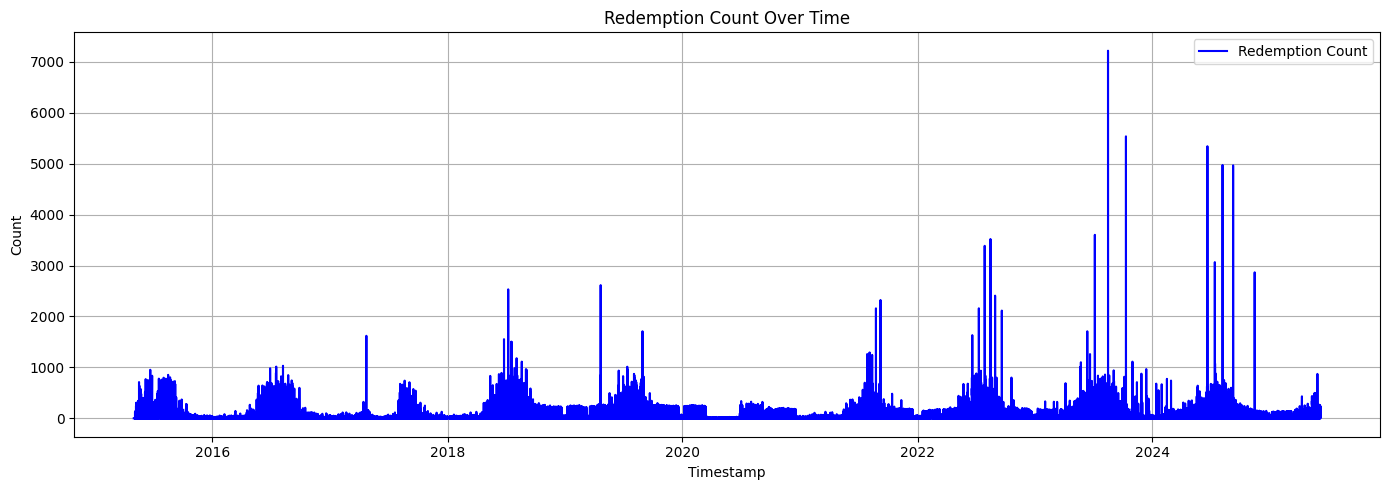

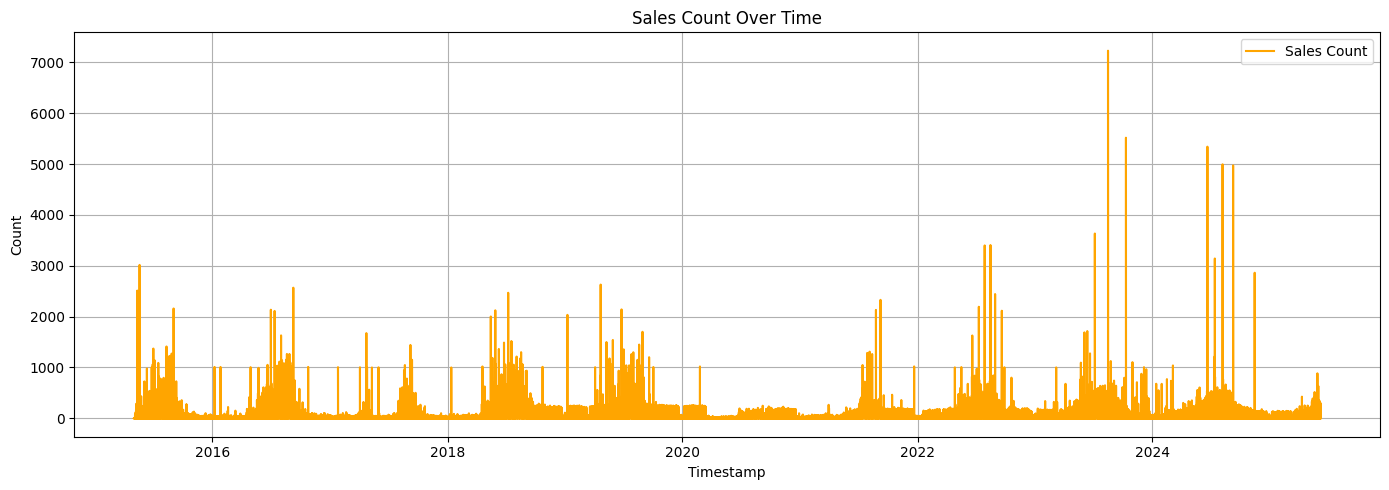


Correlation Matrix:
                  Redemption Count  Sales Count
Redemption Count          1.000000     0.912994
Sales Count               0.912994     1.000000


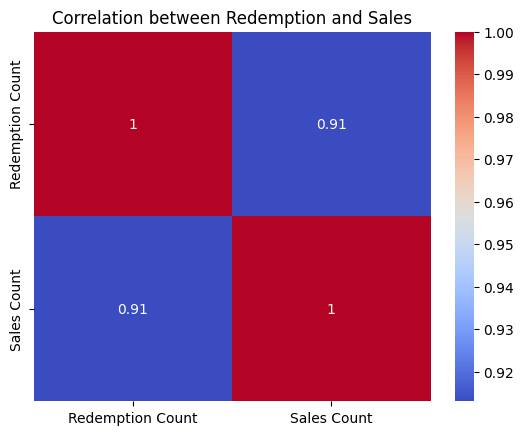

Total missing days: 6
Sample missing dates: DatetimeIndex(['2015-05-02', '2015-05-03', '2018-01-04', '2021-02-21',
               '2021-02-22', '2025-01-26'],
              dtype='datetime64[ns]', freq=None)
Imputed values for missing date 2015-05-02:
_id                 7359182
Redemption Count       1468
Sales Count            1520
dtype: int32
----------------------------------------
Imputed values for missing date 2015-05-03:
_id                 7426413
Redemption Count       1472
Sales Count            1422
dtype: int32
----------------------------------------
Imputed values for missing date 2018-01-04:
_id                 6559655
Redemption Count        526
Sales Count             483
dtype: int32
----------------------------------------
Imputed values for missing date 2021-02-21:
_id                 6964014
Redemption Count        715
Sales Count             569
dtype: int32
----------------------------------------
Imputed values for missing date 2021-02-22:
_id                 

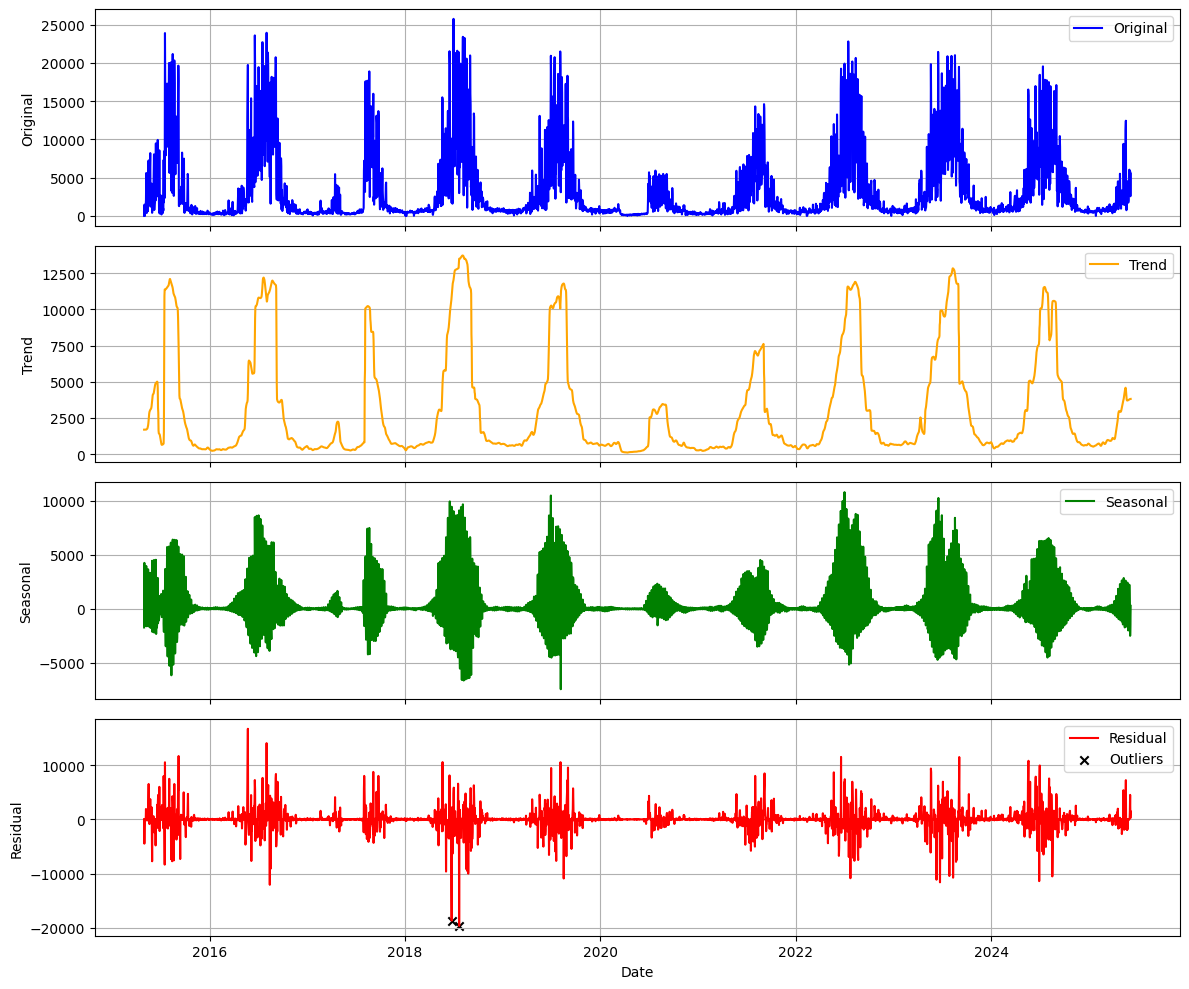

C:\Users\khiza\AppData\Local\Temp\ipykernel_18288\469787667.py:372: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  self.df['is_holiday'] = self.df.index.isin(toronto_holidays).astype(int)



Plotting feature distributions...


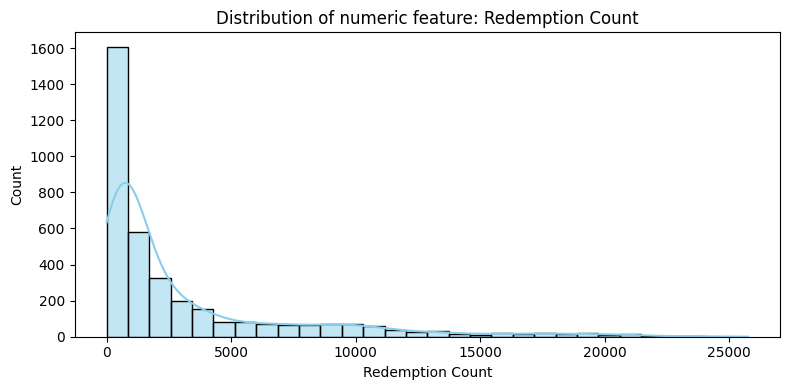

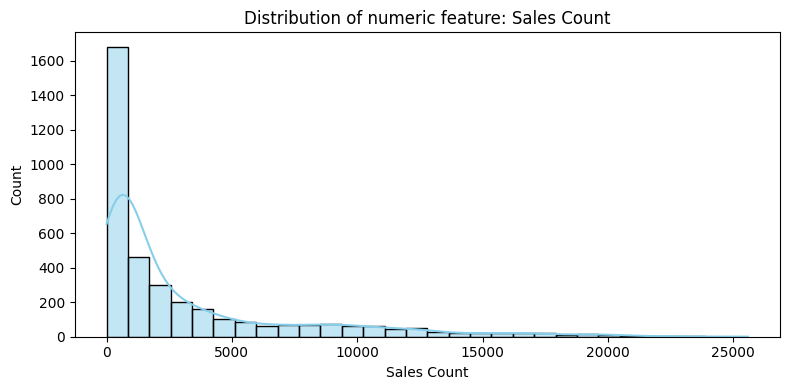


Running models...
Training until validation scores don't improve for 50 rounds
Split 0: Base MAE = 1709.28, LightGBM MAE = 787.26, LSTM MAE = 1284.15
Plotting predictions for: ['Base', 'LightGBM', 'LSTM']


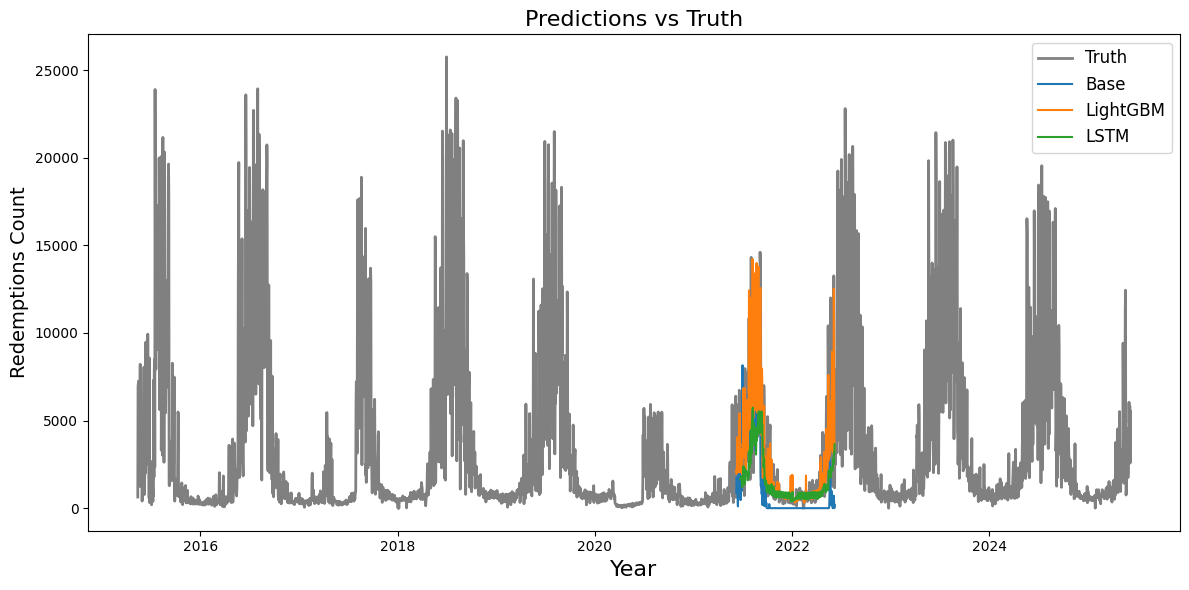

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	train's l1: 703.924	valid's l1: 1037.69
Split 1: Base MAE = 2809.06, LightGBM MAE = 1037.69, LSTM MAE = 1301.39
Plotting predictions for: ['Base', 'LightGBM', 'LSTM']


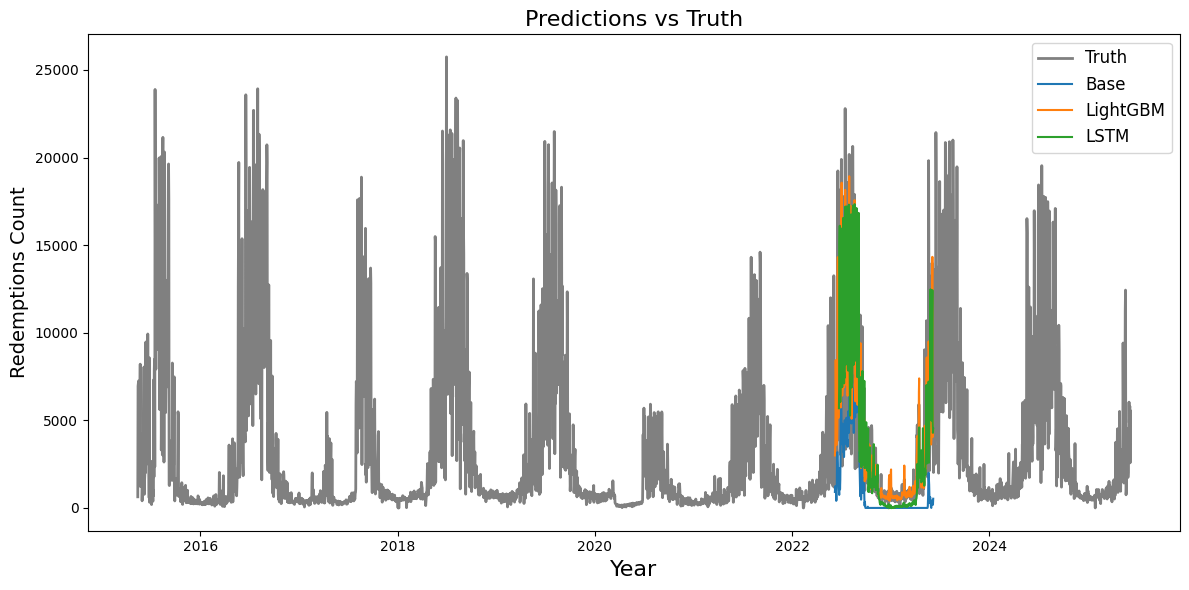

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	train's l1: 783.292	valid's l1: 1068.11
Split 2: Base MAE = 2767.94, LightGBM MAE = 1068.11, LSTM MAE = 1333.69
Plotting predictions for: ['Base', 'LightGBM', 'LSTM']


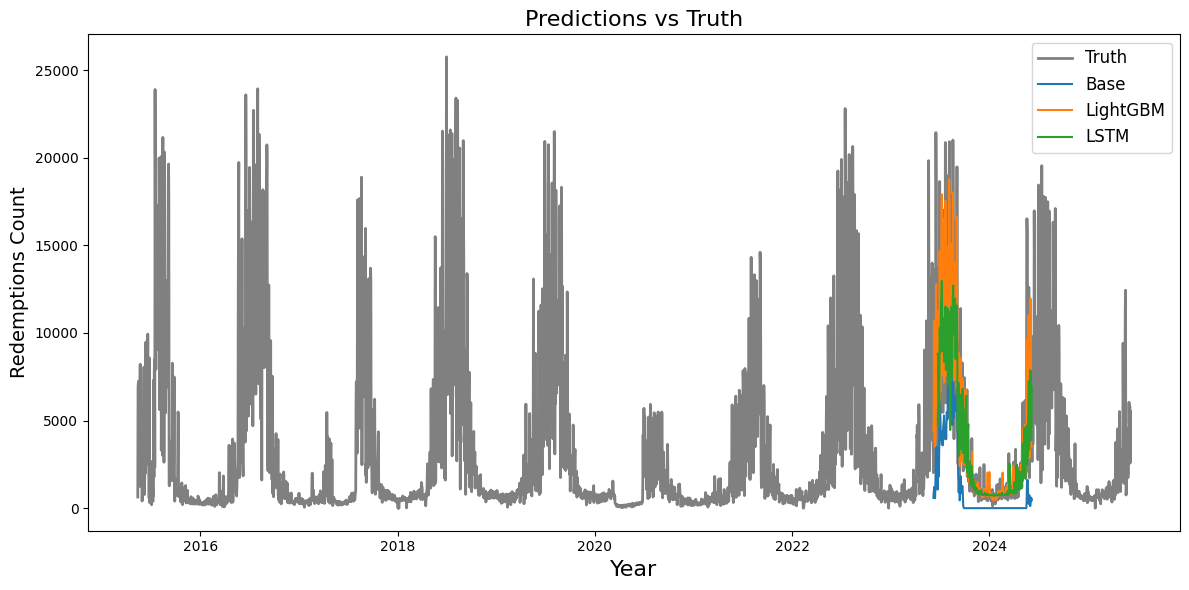

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[468]	train's l1: 714.714	valid's l1: 984.688
Split 3: Base MAE = 2591.55, LightGBM MAE = 984.69, LSTM MAE = 1162.41
Plotting predictions for: ['Base', 'LightGBM', 'LSTM']


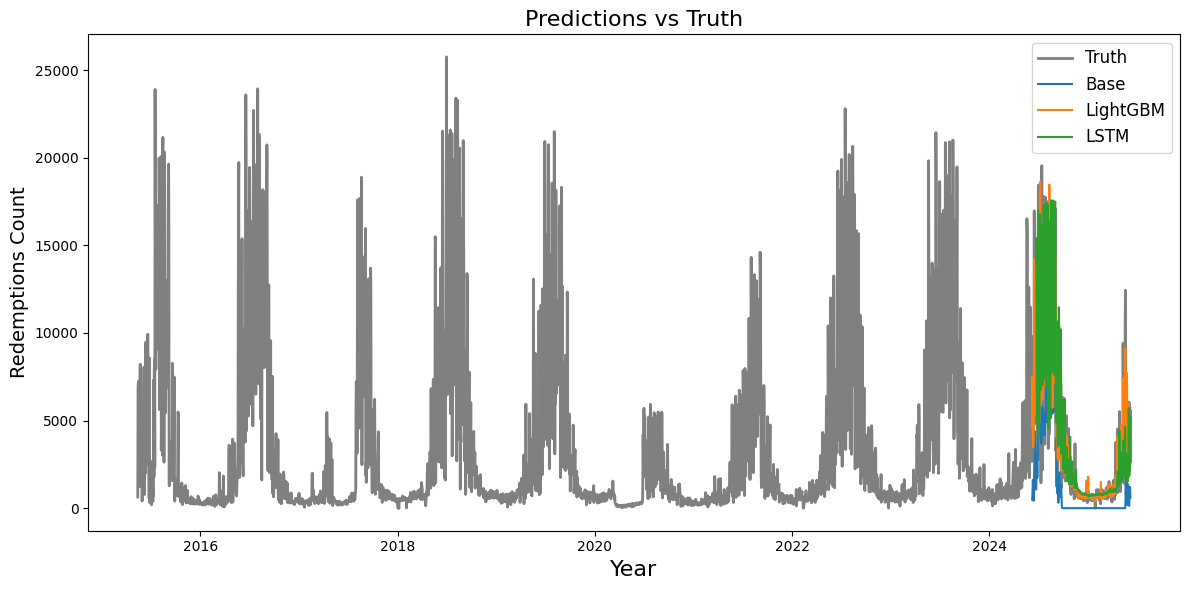


Summary of MAE per split:
      Base  LightGBM     LSTM
0  1709.28    787.26  1284.15
1  2809.06   1037.69  1301.39
2  2767.94   1068.11  1333.69
3  2591.55    984.69  1162.41
MAE results per split:
      Split                                                MAE
0      Base  {0: 1709.2768071069488, 1: 2809.0615789123044,...
1  LightGBM  {0: 787.2619604172497, 1: 1037.692935202914, 2...
2      LSTM  {0: 1284.151642804827, 1: 1301.3860082929475, ...


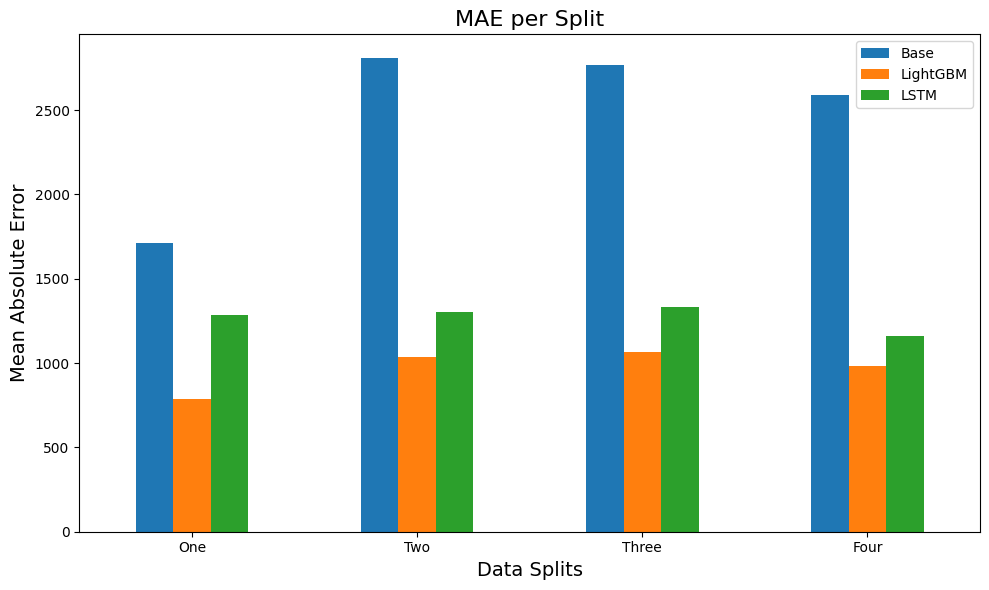

In [4]:
"""
Main script execution.

Loads configuration, reads data, performs EDA, handles missing values,
detects outliers, engineers features, and trains/evaluates the RedemptionModel
using baseline, LightGBM, and LSTM models.
"""

# Load configuration from YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Extract values from configuration
data_path = config['data']['filepath']
timestamp_col = config['data']['timestamp_col']
id_col = config['data']['id_col']
redemption_col = config['data']['redemption_col']
sales_col = config['data']['sales_col']

# Load raw CSV data using a custom loader class
loader = CSVDataLoader(data_path, id_col, timestamp_col, redemption_col, sales_col)
df = loader.load_data()

# Perform basic exploratory data analysis
analyzer = BasicDataAnalyzer(df, redemption_col, sales_col, id_col)
analyzer.perform_basic_eda()

# Handle missing values
mv_handler = MissingValueHandler(df)
missing_days = mv_handler.count_missing_days()

# Resample to daily frequency and impute if needed
df = mv_handler.resample_daily_sum()
if missing_days:
    df = mv_handler.impute_with_historical_avg(df, missing_days)

# Detect outliers using STL decomposition and Isolation Forest
outlier_detector = OutlierDetection(df, config=config)
df = outlier_detector.detect_outliers_stl_isolation(
    numeric_col=redemption_col,
    period=7,
    contamination=None,
    plot=True
)

# Feature engineering using configuration
features_config = config.get('features', {})
fe = FeatureEngineer(df, config=features_config)
df = fe.transform()

# Read column lists directly from config
features_to_plot = config['features_to_plot']
drop_cols = config['drop_columns_lgbm']
keep_cols = config['lstm_keep_columns']

# Plot selected feature distributions
print("\nPlotting feature distributions...")
fe.plot_feature_distributions(columns=[col for col in features_to_plot if col in df.columns])

# Drop unnecessary columns for LightGBM
drop_cols = [col for col in drop_cols if col in df.columns]
df_lgb = df.drop(columns=drop_cols)

# Keep only columns that exist in df for LSTM input
keep_cols = [col for col in keep_cols if col in df.columns]
df_lstm = df[keep_cols].copy()

# Get LightGBM hyperparameters from the configuration file (if any)
lgb_params = config.get('lightgbm_params', {})
lstm_params = config.get('lstm_params', {})
cv_params = config.get('cross_validation', {})

# Instantiate and run the RedemptionModel using baseline, LightGBM, and LSTM models
print("\nRunning models...")
rm = RedemptionModel(df_lgb, redemption_col, df_lstm, lgb_params_dict=lgb_params)
rm.run_models(n_splits=cv_params.get('n_splits'), test_size=cv_params.get('test_size'))

# If the model has results stored, display them
if hasattr(rm, 'results'):
    print("MAE results per split:")
    
    # Convert results dictionary to DataFrame and round values
    df_results = pd.DataFrame(list(rm.results.items()), columns=['Split', 'MAE']).round(2)
    print(df_results)
    
    # Plot MAE summary for visual comparison of model performance
    rm.plot_mae_summary()

